In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import punkt
import pickle
import unicodedata

In [2]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score, precision_score, recall_score
from keras.preprocessing import text, sequence
from keras.layers import Embedding
from keras import layers, models, optimizers
import tensorflow as tf

In [3]:
tf.compat.v1.disable_eager_execution()

In [4]:

df = pd.read_csv(os.path.join('', "Input_Data.csv"))
print("Input data with shape : ", df.shape)
  


Input data with shape :  (1306122, 3)


In [5]:
df.head(5)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
df = df.drop(['qid'],axis = 1)

In [7]:
df.shape

(1306122, 2)

In [8]:
df_sincere = df.loc[df['target'] == 0]
df_insincere = df.loc[df['target'] == 1]

In [9]:
df_sincere_sampled = df_sincere.sample(20000,random_state=42)
df_insincere_sampled = df_insincere.sample(20000,random_state=42)


In [10]:
df_sincere_sampled.shape

(20000, 2)

In [11]:
df_main = pd.concat([df_insincere_sampled,df_sincere_sampled])

In [12]:
df_main.shape

(40000, 2)

In [13]:
df_train, df_test = train_test_split(df_main,train_size = 0.80,random_state=24)

In [14]:
y_train = df_train['target']

In [15]:
y_test = df_test['target']

In [16]:
len(y_test)

8000

In [17]:
# load elmo_train_new
pickle_in_train = open("elmo_train_20k_24.pickle", "rb")
elmo_train_new = pickle.load(pickle_in_train)

# load elmo_train_new
pickle_in_test = open("elmo_test_20k_24.pickle", "rb")
elmo_test_new = pickle.load(pickle_in_test)

In [18]:

# fit xgboost on an imbalanced classification dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier


/mnt/disks/user/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [19]:
# define model
model = XGBClassifier(n_jobs=3, n_estimators=500)


In [20]:
model.fit(elmo_train_new,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=3, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
predictions = model.predict(elmo_test_new)

In [22]:
print(predictions)

[1 0 0 ... 0 0 0]


In [23]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.3f%%" % (accuracy * 100.0))

Accuracy: 88.575%


In [24]:
print('F1 score',f1_score(predictions, y_test))

F1 score 0.8843330802328526


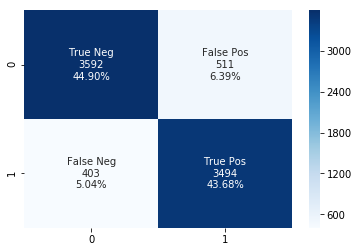

In [25]:
cf_matrix = confusion_matrix(predictions, y_test)

import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
